<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/master/latincircle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install torch
! pip install gpytorch

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# %%
# Imports
import io #Used as buffer
import sys
import matplotlib
import matplotlib.patches as mpatches
import tensorflow as tf # Keras model for MNIST 
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.sigfunc as sgn
import seaborn as sns
import torch
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, \
      tree, neighbors, discriminant_analysis, gaussian_process, preprocessing, impute, decomposition
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
from sklearn.neighbors import KNeighborsClassifier
plt.style.use(['ggplot','style/style.mplstyle'])

In [ ]:
def latin_hypercube(n):
    x1,x2 = np.arange(1, n+1)/n-(1/(2*n)), np.arange(1, n+1)/n-(1/(2*n))
    np.random.shuffle(x2)
    return x1,x2

In [ ]:
#%%
n = 1000
x1,x2 = latin_hypercube(n)
X = np.array([x1, x2]).T
y = np.ones(n)
idx_inner = ((x1-0.5)**2+(x2-0.5)**2)<=0.4**2
idx_outer = np.logical_not(idx_inner)
y[idx_inner] = -1
#%%
Py1inner = 0.1
Py1outer = 0.9

y_inner = y[idx_inner] 
y_inner[:int(np.round(len(y[idx_inner])*Py1inner))] = 1
np.random.shuffle(y_inner)
y[idx_inner] = y_inner

y_outer = y[idx_outer] 
y_outer[:int(np.round(len(y[idx_outer])*(1-Py1outer)))] = -1
np.random.shuffle(y_outer)
y[idx_outer] = y_outer


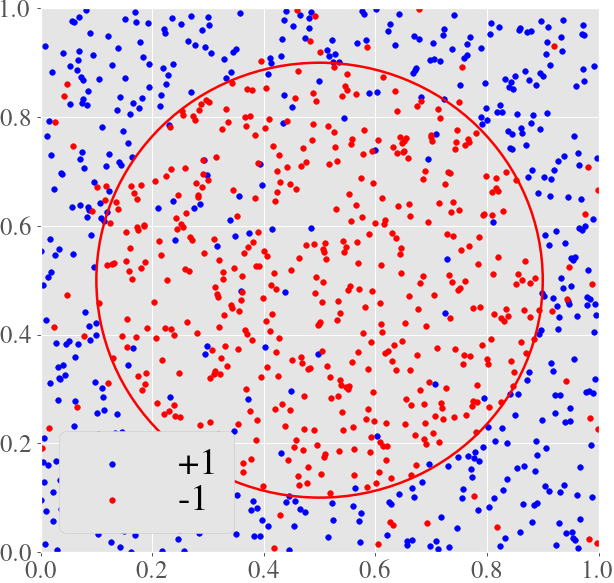

In [199]:
#%%
area = 20
fig, ax = plt.subplots(1,1,figsize=(8, 8), constrained_layout=False, dpi=90)
# plt.figure(figsize=[8,8])
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.scatter(x1[y==1], x2[y==1], s=area, c='b', label='+1')
ax.scatter(x1[y==-1], x2[y==-1], s=area, c='r', label='-1')
circle = plt.Circle((0.5, 0.5), radius=0.4, color='r', fill=False, linewidth=2)
ax.add_artist(circle)
# for i in np.arange(0, 1, 1/n):
#    plt.axvline(i)
#    plt.axhline(i)
plt.legend(loc='lower left', framealpha=1, prop={'size': 30}, labelspacing=0.0)
# plt.legend(loc='upper left',fontsize=2
# plt.show()
path_fig = "drive/My Drive/NIPS2020/results/circle/fig_circle_signal.pdf"
plt.savefig(path_fig, bbox_inches='tight', facecolor='w')

In [ ]:
def plot_decision_surface(X,y,classifier,name,res=0.001):
    area = 20
    x1_min, x1_max = 0,1
    x2_min, x2_max = 0,1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, res),\
        np.arange(x2_min, x2_max, res))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    f = np.array([0 if ((x1-0.5)**2+(x2-0.5)**2<=0.4**2 and z==1) or \
                  ((x1-0.5)**2+(x2-0.5)**2>0.4**2 and z==-1) else np.nan \
                  for x1,x2,z in zip(xx1.ravel(), xx2.ravel(), Z)])
    Z = Z.reshape(xx1.shape)
    fc = f.reshape(xx1.shape)
    fig, ax = plt.subplots(1,1,figsize=(8, 8), constrained_layout=False, dpi=90)
    ax.set_xlim([x1_min,x1_max])
    ax.set_ylim([x2_min,x2_max])
    cmap_own1 = matplotlib.colors.ListedColormap(['cornflowerblue'])
    ax.contourf(xx1, xx2, np.where(Z==1,Z,np.nan), cmap=cmap_own1, alpha=0.5)
    cmap_own2 = matplotlib.colors.ListedColormap(['lightsalmon'])
    ax.contourf(xx1, xx2, np.where(Z==-1,Z,np.nan), cmap=cmap_own2, alpha=0.5)
    cmap_own3 = matplotlib.colors.ListedColormap(['limegreen'])
    ax.contourf(xx1, xx2, fc, cmap=cmap_own3, alpha=1)
    ax.scatter(X[y==1,0], X[y==1,1], s=area, c='b', label='+1')
    ax.scatter(X[y==-1,0], X[y==-1,1], s=area, c='r', label='-1')
    circle = plt.Circle((0.5, 0.5), radius=0.4, color='r', fill=False, linewidth=2)
    ax.add_artist(circle)
    green_patch = mpatches.Patch(color='limegreen')
    blue_patch = mpatches.Patch(color='cornflowerblue')
    red_patch = mpatches.Patch(color='lightsalmon')
    plt.legend([blue_patch,red_patch,green_patch],['+1','-1','misclassified'],loc='lower left', framealpha=0.5, prop={'size': 30}, labelspacing=0.0)
    path_fig = "drive/My Drive/NIPS2020/results/circle/fig_circle_signal_{}.pdf".format(name)
    plt.savefig(path_fig, bbox_inches='tight', facecolor='w')
    return Z
# %%

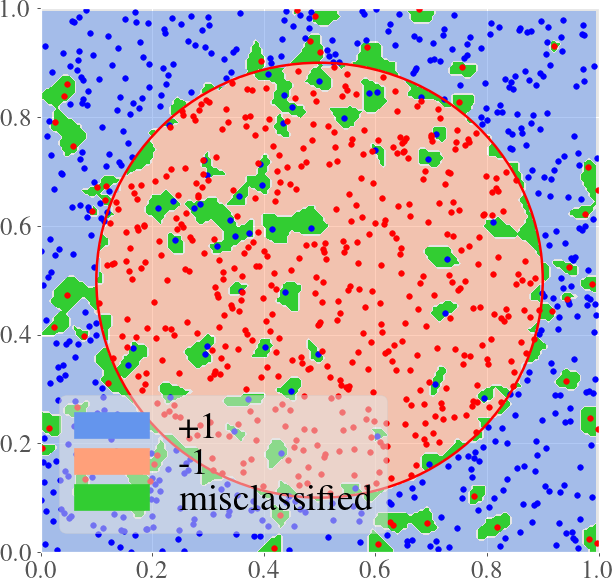

In [ ]:
area = 20
res = 0.005
x1_min, x1_max = 0,1
x2_min, x2_max = 0,1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, res),\
    np.arange(x2_min, x2_max, res))
Z = kNN.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
f = np.array([0 if ((x1-0.5)**2+(x2-0.5)**2<=0.4**2 and z==1) or \
              ((x1-0.5)**2+(x2-0.5)**2>0.4**2 and z==-1) else np.nan \
              for x1,x2,z in zip(xx1.ravel(), xx2.ravel(), Z)])
Z = Z.reshape(xx1.shape)
fc = f.reshape(xx1.shape)
fig, ax = plt.subplots(1,1,figsize=(8, 8), constrained_layout=False, dpi=90)
ax.set_xlim([x1_min,x1_max])
ax.set_ylim([x2_min,x2_max])
cmap_own1 = matplotlib.colors.ListedColormap(['cornflowerblue'])
ax.contourf(xx1, xx2, np.where(Z==1,Z,np.nan), cmap=cmap_own1, alpha=0.5)
cmap_own2 = matplotlib.colors.ListedColormap(['lightsalmon'])
ax.contourf(xx1, xx2, np.where(Z==-1,Z,np.nan), cmap=cmap_own2, alpha=0.5)
cmap_own3 = matplotlib.colors.ListedColormap(['limegreen'])
ax.contourf(xx1, xx2, fc, cmap=cmap_own3, alpha=1)
ax.scatter(X[y==1,0], X[y==1,1], s=area, c='b', label='+1')
ax.scatter(X[y==-1,0], X[y==-1,1], s=area, c='r', label='-1')
circle = plt.Circle((0.5, 0.5), radius=0.4, color='r', fill=False, linewidth=2)
ax.add_artist(circle)
green_patch = mpatches.Patch(color='limegreen')
blue_patch = mpatches.Patch(color='cornflowerblue')
red_patch = mpatches.Patch(color='lightsalmon')
plt.legend([blue_patch,red_patch,green_patch],['+1','-1','misclassified'],loc='lower left', framealpha=0.5, prop={'size': 30}, labelspacing=0.0)

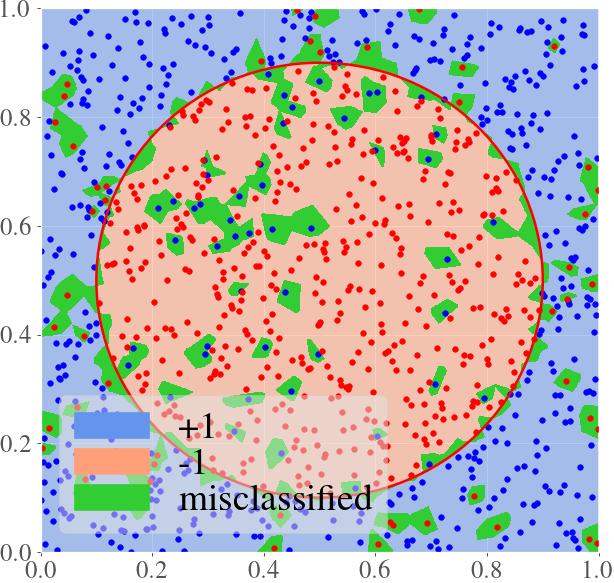

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

kNN = KNeighborsClassifier(n_neighbors=1)
kNN.fit(X,y)
# %%
Z = plot_decision_surface(X, y, classifier=kNN, name='kNN')

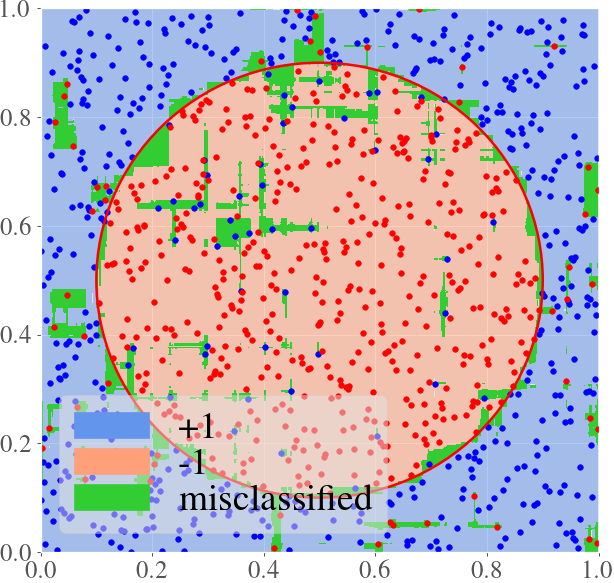

In [ ]:
# %%
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8),
                         algorithm="SAMME",
                         n_estimators=100)
bdt.fit(X, y)
Z = plot_decision_surface(X, y, classifier=bdt, name='AdaBoost')

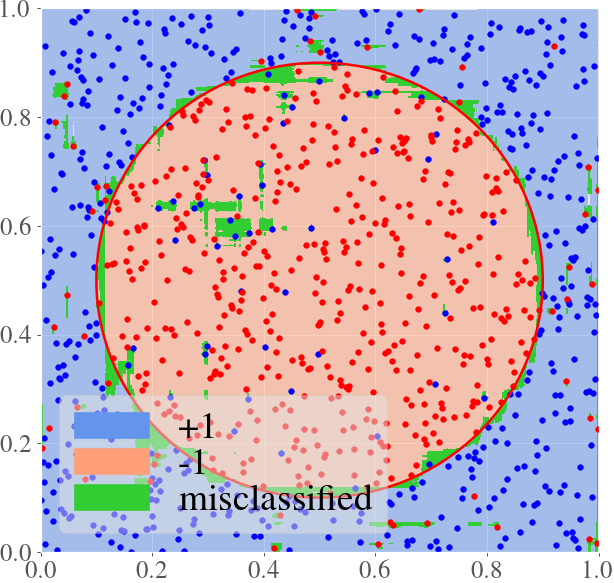

In [ ]:
# %%
from sklearn.ensemble import RandomForestClassifier
# Create and fit a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X,y)
Z = plot_decision_surface(X, y, classifier=rf, name='RandomForest')

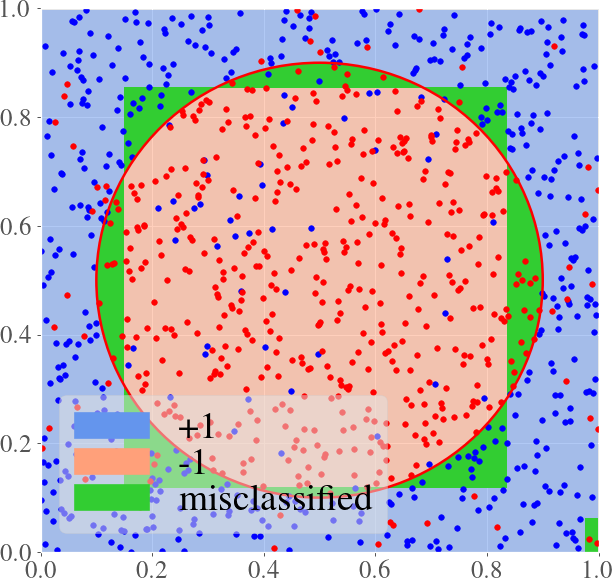

In [ ]:
#%%
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':range(3,100)}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X=X, y=y)
tree_model = clf.best_estimator_
Z = plot_decision_surface(X, y, classifier=tree_model, name='DecisionTree')

Number of nodes in the last tree is: 1 with ccp_alpha: 0.059521406888711575


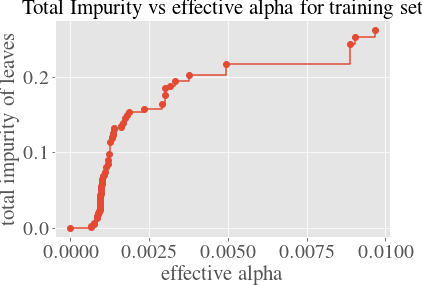

In [ ]:
# %%
cart = DecisionTreeClassifier()
path = cart.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

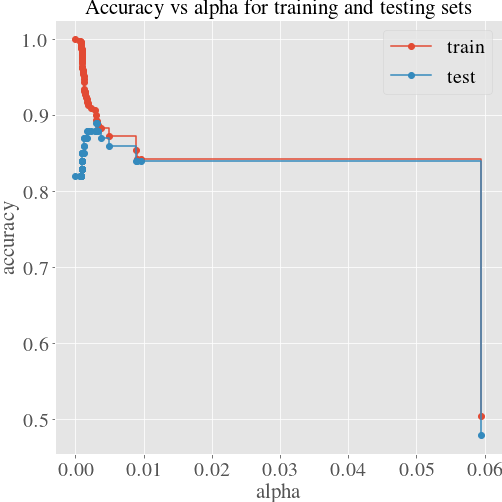

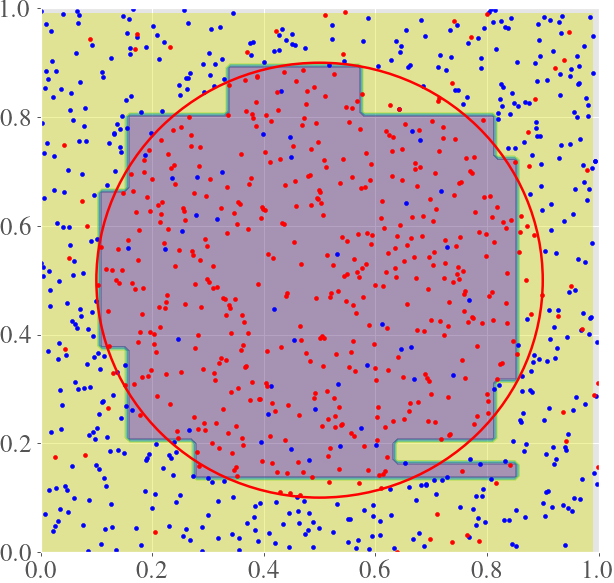

In [ ]:
#%%
n = 100
x1_test,x2_test = latin_hypercube(n)
X_test = np.array([x1_test, x2_test]).T
y_test = np.ones(n)
idx_inner_test = ((x1_test-0.5)**2+(x2_test-0.5)**2)<=0.4**2
idx_outer_test = np.logical_not(idx_inner_test)
y_test[idx_inner_test] = -1

Py1inner = 0.1
Py1outer = 0.9

y_inner = y_test[idx_inner_test] 
y_inner[:int(np.round(len(y_test[idx_inner_test])*Py1inner))] = 1
np.random.shuffle(y_inner)
y_test[idx_inner_test] = y_inner

y_outer = y_test[idx_outer_test] 
y_outer[:int(np.round(len(y_test[idx_outer_test])*(1-Py1outer)))] = -1
np.random.shuffle(y_outer)
y_test[idx_outer_test] = y_outer
#%%
train_scores = [clf.score(X, y) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()
j = np.argmax(test_scores)
#%%
cart = DecisionTreeClassifier(ccp_alpha=ccp_alphas[j])
cart.fit(X, y)
Z = plot_decision_surface(X, y, classifier=cart)
# %%